In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path

In [2]:
MASTER = Path("../data/processed/master_teams_2000_2019.csv")
TAB_OUT = Path("../data/processed")
FIG_OUT = Path("../plots/final_version")
TAB_OUT.mkdir(parents=True, exist_ok=True)
FIG_OUT.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(MASTER, parse_dates=["season_date"])

In [4]:
vars_num = ["W", "RunDiff", "ERA", "HR", "R", "RA", "G", "L"]
vars_pred = ["RunDiff", "ERA", "HR"]

In [5]:
palette = cm.tab10(np.linspace(0, 1, len(vars_num)))
color_map = {var: palette[i] for i, var in enumerate(vars_num)}

In [6]:
mode_dict = {}
for c in vars_num:
    m = df[c].mode()
    mode_dict[c] = m.iloc[0] if not m.empty else np.nan

desc = pd.DataFrame(index=vars_num)
desc["count"] = df[vars_num].count()
desc["mean"] = df[vars_num].mean()
desc["median"] = df[vars_num].median()
desc["mode"] = pd.Series(mode_dict)
desc["std"] = df[vars_num].std()
desc["var"] = df[vars_num].var()
desc["min"] = df[vars_num].min()
desc["Q1"] = df[vars_num].quantile(0.25)
desc["Q3"] = df[vars_num].quantile(0.75)
desc["IQR"] = desc["Q3"] - desc["Q1"]
desc["max"] = df[vars_num].max()

desc.to_csv(TAB_OUT / "descriptivas_central_dispersion.csv", float_format="%.4f")
print("Tendencia central y dispersión de las variables numéricas")
desc.head(10)

Tendencia central y dispersión de las variables numéricas


,count,mean,median,mode,std,var,min,Q1,Q3,IQR,max
W,600,80.970000,81.000,86.00,11.786460,138.920634,43.00,72.00,90.0000,18.0000,116.00
RunDiff,600,0.000000,2.000,54.00,111.107116,12344.791319,-337.00,-87.00,81.2500,168.2500,300.00
ERA,600,4.248000,4.205,4.01,0.534891,0.286109,2.94,3.86,4.6025,0.7425,5.71
HR,600,173.465000,170.000,161.00,36.866208,1359.117304,91.00,148.00,199.0000,51.0000,307.00
R,600,740.668333,735.000,735.00,83.211830,6924.208678,513.00,684.00,795.2500,111.2500,978.00
RA,600,740.668333,733.000,715.00,88.933948,7909.247076,525.00,676.75,804.0000,127.2500,981.00
G,600,161.960000,162.000,162.00,0.313949,0.098564,161.00,162.00,162.0000,0.0000,163.00
L,600,80.970000,80.500,76.00,11.761788,138.339666,46.00,72.00,90.0000,18.0000,119.00


In [7]:
outlier_rows = []
for c in vars_num:
    Q1 = desc.loc[c, "Q1"]
    Q3 = desc.loc[c, "Q3"]
    IQR = desc.loc[c, "IQR"]
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    mask = (df[c] < low) | (df[c] > high)
    if mask.any():
        tmp = df.loc[mask, ["yearID", "teamID", "name", c]].copy()
        tmp["variable"] = c
        tmp["low_threshold"] = low
        tmp["high_threshold"] = high
        outlier_rows.append(tmp)

if outlier_rows:
    outliers_df = pd.concat(outlier_rows, ignore_index=True)
else:
    outliers_df = pd.DataFrame(
        columns=[
            "yearID",
            "teamID",
            "name",
            "valor",
            "variable",
            "low_threshold",
            "high_threshold",
        ]
    )

outliers_df.to_csv(TAB_OUT / "outliers_IQR.csv", index=False)
print("Detección de outliers usando IQR")
outliers_df.count()

Detección de outliers usando IQR


yearID            71
teamID            71
name              71
W                  1
variable          71
low_threshold     71
high_threshold    71
HR                 4
R                  5
G                 60
L                  1
dtype: int64

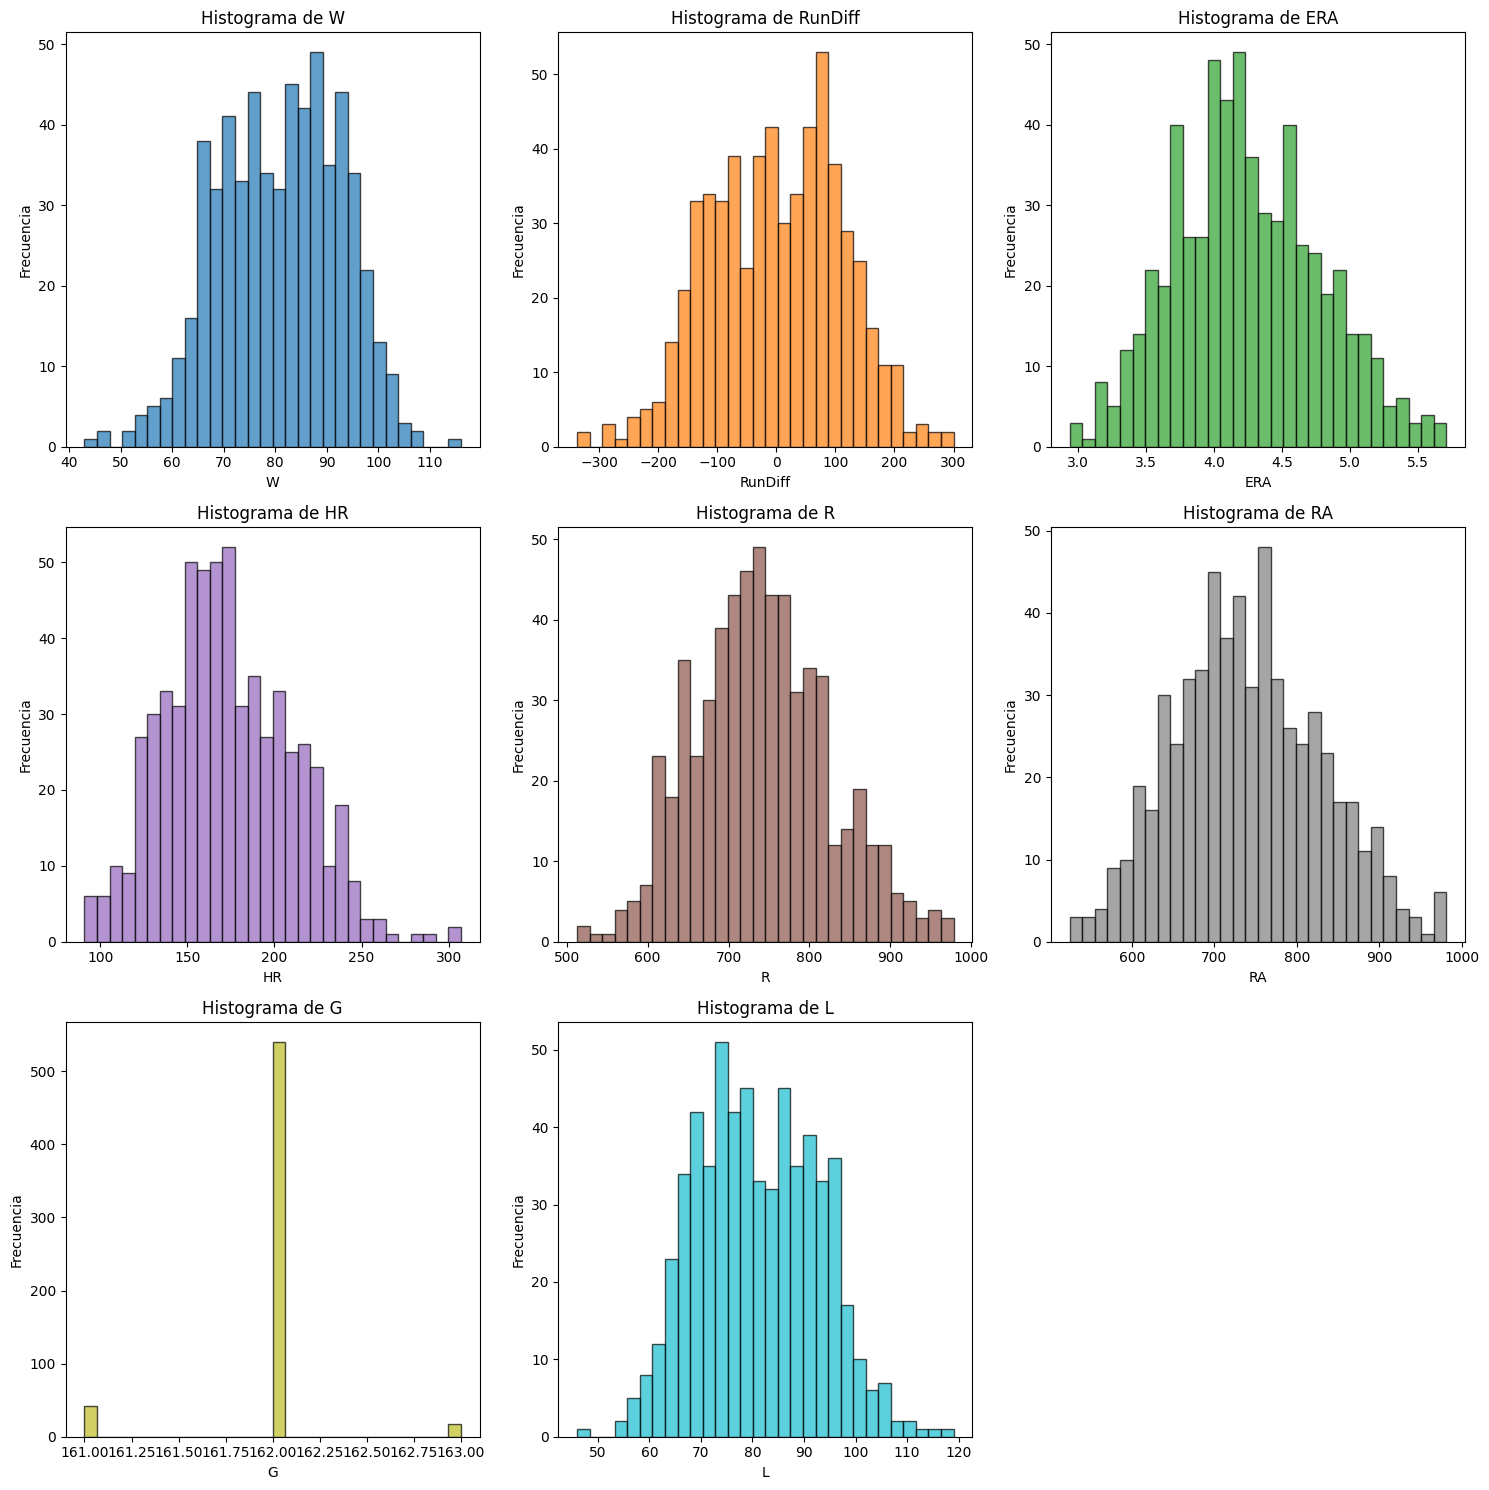

In [8]:
rows = math.ceil(len(vars_num) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, c in enumerate(vars_num):
    ax = axes.flatten()[i]
    ax.hist(df[c].dropna(), bins=30, color=color_map[c], edgecolor="black", alpha=0.7)
    ax.set_title(f"Histograma de {c}")
    ax.set_xlabel(c)
    ax.set_ylabel("Frecuencia")

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.savefig(FIG_OUT / "all_histograms.png", dpi=150, transparent=True)
plt.show()
plt.close()

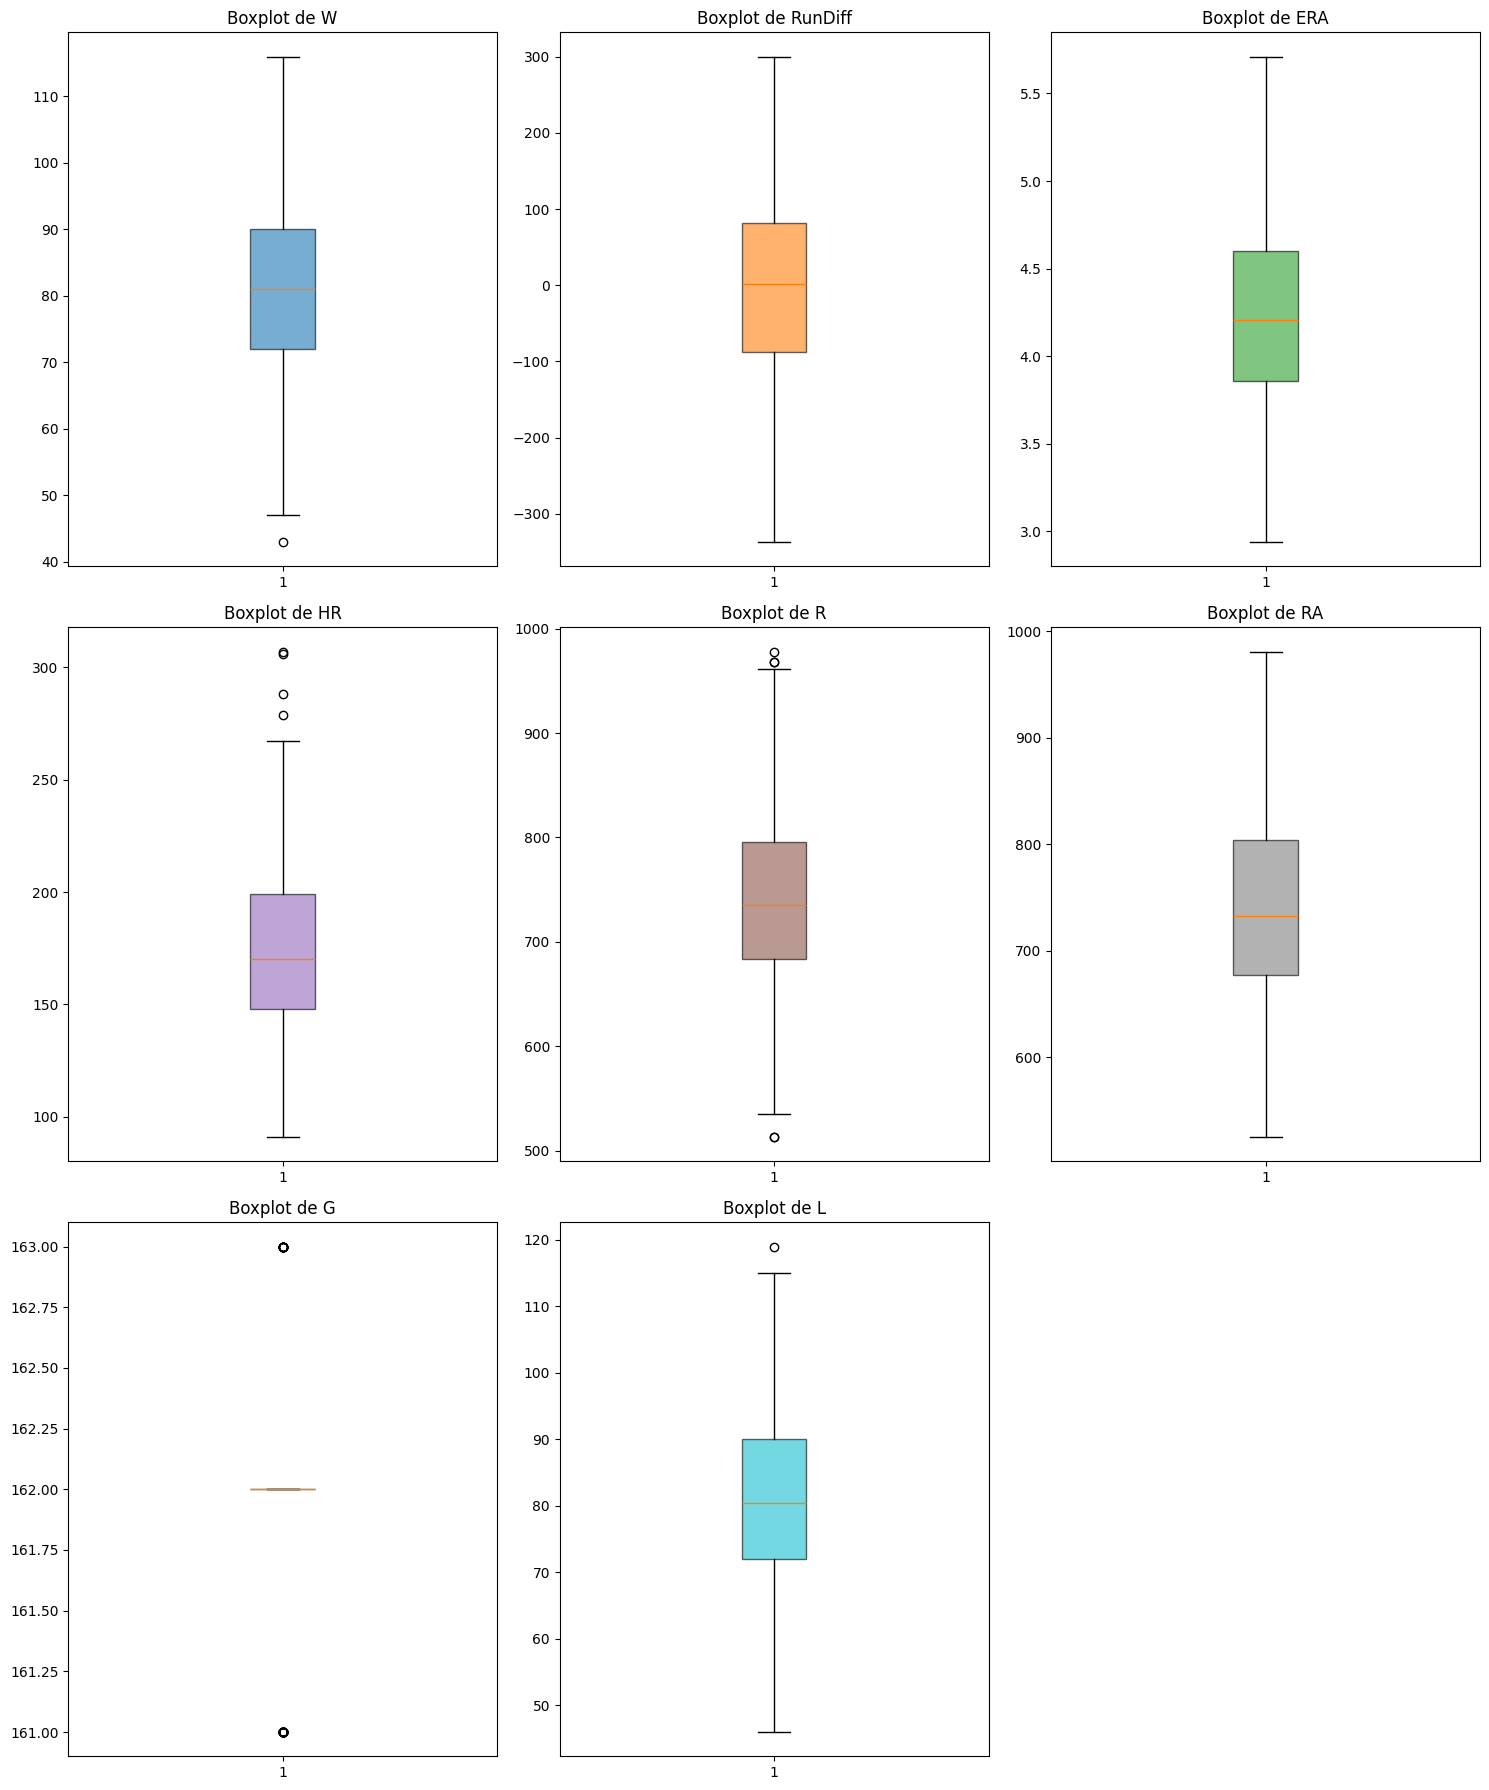

In [9]:
import math

n = len(vars_num)
nrows = 3
ncols = math.ceil(n / nrows)

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 6 * nrows))

axes = axes.flatten()

for i, c in enumerate(vars_num):
    axes[i].boxplot(
        df[c].dropna(),
        vert=True,
        patch_artist=True,
        boxprops=dict(facecolor=color_map[c], color="black", alpha=0.6),
    )
    axes[i].set_title(f"Boxplot de {c}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(FIG_OUT / "all_boxplots.png", dpi=150, transparent=True)
plt.show()
plt.close()

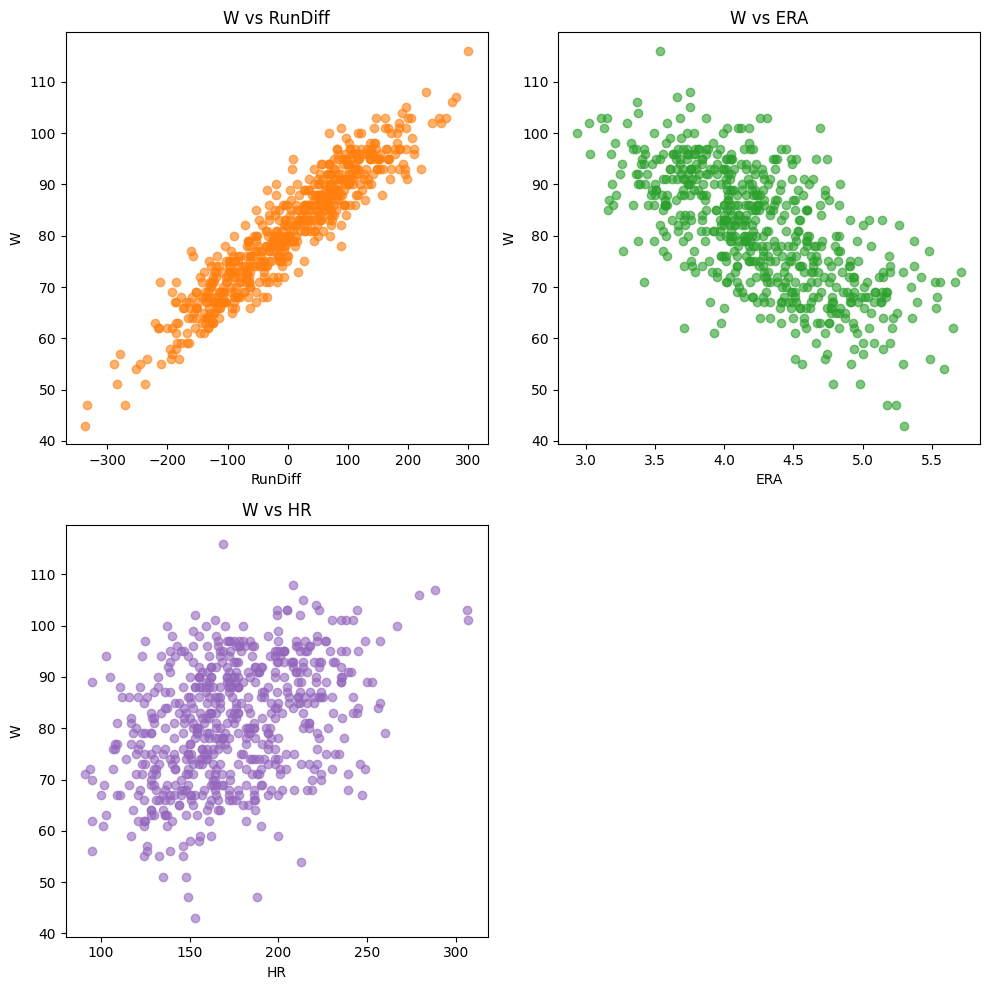

In [10]:
n = len(vars_pred)
rows = 2
cols = math.ceil(n / rows)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

axes = axes.flatten()

for i, x in enumerate(vars_pred):
    ax = axes[i]
    ax.scatter(df[x], df["W"], alpha=0.6, color=color_map[x])
    ax.set_title(f"W vs {x}")
    ax.set_xlabel(x)
    ax.set_ylabel("W")

# eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(FIG_OUT / "all_scatter_W.png", dpi=150, transparent=True)
plt.show()
plt.close()

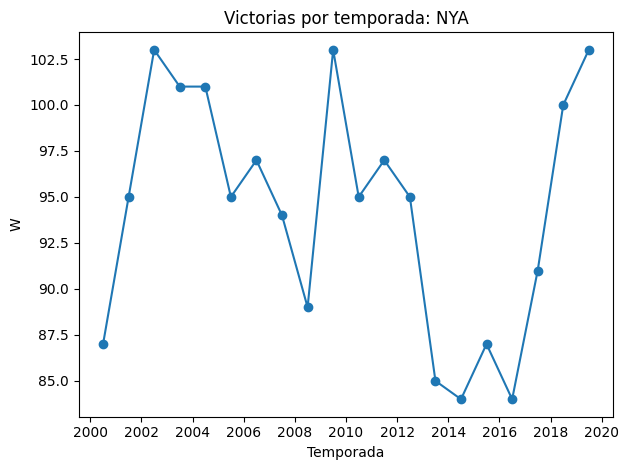

In [11]:
team_example = "NYA"
serie = df[df["teamID"] == team_example].sort_values("season_date")
if not serie.empty:
    plt.figure()
    plt.plot(serie["season_date"], serie["W"], marker="o", color=color_map["W"])
    plt.title(f"Victorias por temporada: {team_example}")
    plt.xlabel("Temporada")
    plt.ylabel("W")
    plt.tight_layout()
    plt.savefig(FIG_OUT / f"ts_W_{team_example}.png", dpi=150, transparent=True)
    plt.show()
    plt.close()

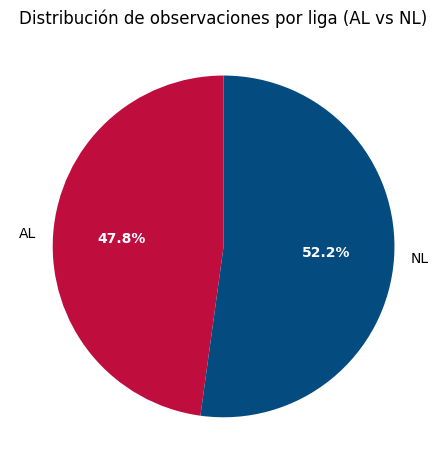

In [12]:
league_colors = {
    "AL": "#BF0D3E",
    "NL": "#044B7F",
}

ligas_counts = df["lgID"].value_counts().sort_index()

fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(
    ligas_counts.values,
    labels=ligas_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=[league_colors.get(lg, "grey") for lg in ligas_counts.index],
)

plt.setp(autotexts, color="white", fontweight="bold")

ax.set_title("Distribución de observaciones por liga (AL vs NL)")
fig.tight_layout()
fig.savefig(FIG_OUT / "pie_ligas_colored.png", dpi=150, transparent=True)
plt.show()
plt.close(fig)